In [20]:
import sys
sys.path.append('./models/')
from Model import Model
from Arima import ARIMA_Model, VAR_m
from exponential_regression import ExponentialRegression, MultiDimensionalExponentialRegression
from SIRH  import *
from LinearRegression import *
from BayesianRegression import *
from moving_average import MovingAverage, MovingAverageMulti
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from evaluate_model import evaluate_model, evaluate_model_multi, evaluate_model_multi_RMSE, evaluate_model_RMSE
import json

In [21]:
df=pd.read_csv('hopitalized_and_infectious.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
n_hospitalized=np.array(df['hospitalized'])
n_infectious=np.array(df['n_infectious'])


In [22]:
# importing mobility from the csv file
df_mobility=pd.read_csv('mobility_bis.csv')
df_mobility.drop(columns=['Unnamed: 0'], inplace=True)
mobility=np.array(df_mobility['mobility'])


In [23]:
relier_les_points=[]
for i in range(len(mobility)): 
    if i + 7 < len(mobility): 
        if i % 7 ==0:
            relier_les_points.append(mobility[i])
        else: 
            decalage=i-7*(i//7)
            res = (1-decalage/7)*mobility[7*(i//7)] + (decalage/7)*mobility[7*(i//7)+7]

            relier_les_points.append(res)
    else:
        relier_les_points.append(mobility[i])
mobility_smoothed=np.array(relier_les_points)
data3D=np.array([n_hospitalized, n_infectious, mobility_smoothed])

In [24]:
myarima=ARIMA_Model()
mysirh=SIRH_model_2()
mysirh.choose_model(True, False, True)
mybayes=BayesianRegressionModel()
mylinear=LinearRegressionModel()
alphas=np.array([0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
indexs_points=[[20*i] for i in range(1, 15) ]
weights=np.concatenate((np.array([0.5]), alphas * 0.5))
    

In [25]:
def generate_prediction(model: Model, data: np.array, alphas: list, start: int, reach: int, weights: list):
    print(type(start))
    model.train(train_dates = [i for i in range(start)], data = data[:start] )
    intervals=[]
    for alpha in alphas:
        print(reach, alpha)
        prediction, interval = model.predict(reach, alpha)
        interval_low=interval[0][-1]
        interval_high=interval[1][-1]
        intervals.append((interval_low, interval_high))
    prediction=prediction[-1]
    return intervals, prediction

In [45]:
start_date=30
horizon=10
reach=[i for i in range(1, 10)]
predict=[]
CI=[]
for R in reach:
    print(R)
    print(type(R))
    intervals, prediction=generate_prediction(model=myarima, data=n_hospitalized, alphas=alphas, start=start_date, reach=R, weights=weights)
    predict.append(prediction)
    CI.append(intervals[0])

1
<class 'int'>
<class 'int'>


c:\Users\grego\Miniconda3\envs\E4C\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\grego\Miniconda3\envs\E4C\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\grego\Miniconda3\envs\E4C\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1 0.02
1 0.05
1 0.1
1 0.2
1 0.3
1 0.4
1 0.5
1 0.6
1 0.7
1 0.8
1 0.9
2
<class 'int'>
<class 'int'>


c:\Users\grego\Miniconda3\envs\E4C\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2 0.02
2 0.05
2 0.1
2 0.2
2 0.3
2 0.4
2 0.5
2 0.6
2 0.7
2 0.8
2 0.9
3
<class 'int'>
<class 'int'>


c:\Users\grego\Miniconda3\envs\E4C\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3 0.02
3 0.05
3 0.1
3 0.2
3 0.3
3 0.4
3 0.5
3 0.6
3 0.7
3 0.8
3 0.9
4
<class 'int'>
<class 'int'>


c:\Users\grego\Miniconda3\envs\E4C\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4 0.02
4 0.05
4 0.1
4 0.2
4 0.3
4 0.4
4 0.5
4 0.6
4 0.7
4 0.8
4 0.9
5
<class 'int'>
<class 'int'>


c:\Users\grego\Miniconda3\envs\E4C\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5 0.02
5 0.05
5 0.1
5 0.2
5 0.3
5 0.4
5 0.5
5 0.6
5 0.7
5 0.8
5 0.9
6
<class 'int'>
<class 'int'>


c:\Users\grego\Miniconda3\envs\E4C\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6 0.02
6 0.05
6 0.1
6 0.2
6 0.3
6 0.4
6 0.5
6 0.6
6 0.7
6 0.8
6 0.9
7
<class 'int'>
<class 'int'>


c:\Users\grego\Miniconda3\envs\E4C\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7 0.02
7 0.05
7 0.1
7 0.2
7 0.3
7 0.4
7 0.5
7 0.6
7 0.7
7 0.8
7 0.9
8
<class 'int'>
<class 'int'>


c:\Users\grego\Miniconda3\envs\E4C\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8 0.02
8 0.05
8 0.1
8 0.2
8 0.3
8 0.4
8 0.5
8 0.6
8 0.7
8 0.8
8 0.9
9
<class 'int'>
<class 'int'>
9 0.02
9 0.05
9 0.1
9 0.2
9 0.3
9 0.4
9 0.5
9 0.6
9 0.7
9 0.8
9 0.9


c:\Users\grego\Miniconda3\envs\E4C\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


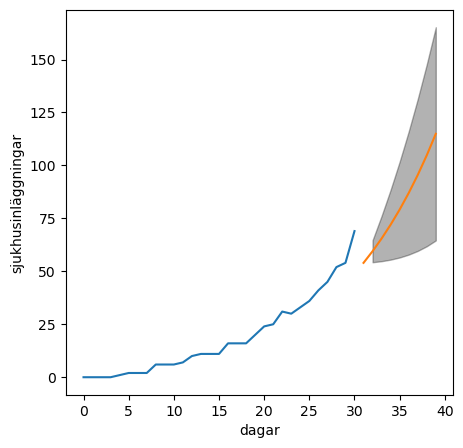

In [67]:
dates=np.arange(start_date+1,start_date+horizon)
ci = np.asarray(CI)
plt.figure(figsize=(5,5), dpi=100)
plt.plot(n_hospitalized[0:start_date+1], label='training')
plt.plot(dates,predict)
plt.fill_between(dates,ci[:,0], ci[:,1], color='black', alpha=.3, label='95% confidence interval')
plt.xlabel('dagar')
plt.ylabel('sjukhusinläggningar')
plt.savefig('linear.pdf')

In [68]:
ci = np.asarray(CI)
print(CI)

[(nan, nan), (54.295954598605235, 64.68026276074951), (54.79112803460012, 76.16910645992081), (55.52499756834351, 88.51949340820451), (56.5426038143798, 101.78728358781596), (57.895234172853485, 116.03132221983543), (59.641183261868996, 131.3135199250778), (61.846598335591274, 147.69892364817332), (64.58641834780562, 165.2557763591972)]
